<a href="https://colab.research.google.com/github/MuhammadRhakan/final_project/blob/main/2_Deployment_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install leidenalg igraph networkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 146.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 157.0 MB/s eta 0:00:00


In [ ]:
import nltk
import kagglehub
import sys
import h5py
import random
import leidenalg
import json

import pandas as pd
import numpy as np
import networkx as nx
import igraph as ig
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import networkit as nk

from kagglehub.datasets import KaggleDatasetAdapter
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from scipy.sparse import csr_matrix, vstack
from collections import Counter

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")

/tmp/ipython-input-3-193580186.py:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")


In [ ]:
#fill missing last update date
def fill_empty_date(data, features):
  data = data.copy()
  for col in features:
    data[col] = pd.to_datetime(data[col], utc=True)

  data[features[1]] = data[features[1]].fillna(data[features[0]])

  return data


#get latest 5 years data
def get_latest_five_years(data, features):
  data = fill_empty_date(data, features)
  latest_year = data[features[0]].max().year
  last_five_year = latest_year - 5

  data = data[(data[features[0]].dt.year > last_five_year) & (data[features[1]].dt.year > last_five_year)]

  return data


#basic cleaning
def initial_cleaning_phase(course):
  course = get_latest_five_years(course, ['published_time', 'last_update_date'])
  null_values = course[(course['num_lectures'] == 0) |
                (course['content_length_min'] == 0) |
                ((course['avg_rating'] == 0) & (course['num_reviews'] > 0))].index
  clean_data = course.drop(index=null_values).dropna()

  return clean_data

In [ ]:
course = course[course['language'].isin({'English'})]
course = initial_cleaning_phase(course)
print(course.shape)

(89225, 20)


In [ ]:
#separate numeric and non-numeric attributes
def get_numerical_attributes(data, exclude):
  numerical = []
  print(f"Numerical Attributes:")
  for num in data.select_dtypes(include = 'number').drop(columns='id').columns:
    if num != exclude:
      numerical.append(num)
      print(f"• {num}")

  return numerical


#handle outliers using clips
def outlier_clipping(data, features, par, skip):
  data = data.copy()
  data.loc[data[skip] == 0, skip] = np.nan

  clip = data.copy()
  for col in features:
    upper = data[col].quantile(par)
    lower = data[col].quantile(1-par)
    clip[col] = clip[col].clip(upper=upper, lower=lower)

  transformed = clip.copy()
  transformed[features] = np.sqrt(transformed[features])

  return clip, transformed


#handle outliers using trim
def outlier_trimming(data, features, par, skip, fg1, fg2):
  data = data.copy()
  data.loc[data[skip] == 0, skip] = np.nan

  trim = data.copy()
  for col in features:
    outliers = data[col].quantile(par)
    trim = trim[trim[col] < outliers]

  transformed = trim.copy()
  transformed[fg1] = np.log1p(transformed[fg1])
  transformed[fg2] = np.sqrt(transformed[fg2])
  transformed[skip] = np.sqrt(transformed[skip])

  return trim, transformed


#label categorical values
def features_labeling(data, features):
  label = data.copy()
  label[features[0]] = label[features[0]].map({True: 1, False: 0})

  label['rounded_rating'] = (label[features[1]].copy()).astype(int)
  label['rating_label'] = label['rounded_rating'].apply(lambda x: 'bad' if x < 3 else ('mid' if x == 3 else 'good'))

  return label


#check distributions
def box_visualization(data, features):
  sns.boxplot(data[features])
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [ ]:
numerical = get_numerical_attributes(course, exclude='avg_rating')
course_completed = features_labeling(course, features=['is_paid','avg_rating'])

course_clip, course_clip_scaled = outlier_clipping(course_completed,
                                                   features=numerical,
                                                   par=0.9,
                                                   skip='price')

course_trim, course_trim_scaled = outlier_trimming(course_completed,
                                                   features=numerical,
                                                   par=0.9,
                                                   skip='price',
                                                   fg1=['num_subscribers', 'num_reviews', 'num_comments'],
                                                   fg2=['num_lectures', 'content_length_min'])

Numerical Attributes:
• price
• num_subscribers
• num_reviews
• num_comments
• num_lectures
• content_length_min


In [ ]:
def trace_item_index(data, feature):
  new_order = data[feature].reset_index()
  new_order = new_order.rename(columns={'index': 'Raw index', 'id': 'Item ID'})

  return new_order

indices = trace_item_index(course_trim, feature='id')
indices

,Raw index,Item ID
0,180,17704.0
1,1113,51648.0
2,1129,51942.0
3,1255,57585.0
4,1441,64734.0
...,...,...
52899,209724,4912840.0
52900,209725,4913148.0
52901,209727,4913922.0
52902,209729,4913954.0


In [ ]:
def semantic_preprocessing(data, features, id):
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()

  combined_text =[]
  for col in features:
    semantic = data[col].str.lower()
    semantic = semantic.apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words]))
    combined_text.append(semantic)

  semantic = pd.concat(combined_text, axis=1).apply(lambda x: ' '.join(x), axis=1)

  vectorizer = TfidfVectorizer(max_features=1000, min_df=3, max_df=0.9, ngram_range=(1, 3), dtype=np.float32)
  tfidf_matrix = vectorizer.fit_transform(semantic)
  tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
  tfidf_df[id] = data[id].values
  tfidf_df = tfidf_df.set_index(id)

  return tfidf_matrix.toarray(), tfidf_df

In [ ]:
def numerical_preprocessing(data, features, id):
  correlation_score = data[features].corr()
  upper = correlation_score.where(np.triu(np.ones(correlation_score.shape), k=1).astype(bool))
  redundant = [col for col in upper.columns if any(upper[col] > 0.85)]

  numeric = data[features].drop(columns=redundant)

  scaler = MinMaxScaler()
  normalized_matrix = scaler.fit_transform(numeric)
  normalized_df = pd.DataFrame(data=normalized_matrix, columns=numeric.columns)
  normalized_df[id] = data[id].values
  normalized_df = normalized_df.set_index(id)

  return normalized_matrix, normalized_df

In [ ]:
def nominal_preprocessing(data, features, id):
  nominal = data[features].copy().reset_index(drop=True)

  for col in nominal.columns:
    if nominal[col].dtype == 'datetime64[ns, UTC]':
      nominal[col] = nominal[col].dt.year.astype(str)

  nominal = nominal.loc[:, nominal.nunique() > 1]

  multiattribute_df = pd.get_dummies(nominal)
  multiattribute_matrix = multiattribute_df.values
  multiattribute_df[id] = data[id].values
  multiattribute_df = multiattribute_df.set_index(id)

  return multiattribute_matrix, multiattribute_df

In [ ]:
semantic_matrix, semantic_df = semantic_preprocessing(course_trim, features=['title', 'headline', 'topic'], id='id')
numeric_matrix, numeric_df = numerical_preprocessing(course_trim_scaled, numerical, id='id')
nominal_matrix, nominal_df = nominal_preprocessing(course_trim, features=['is_paid', 'category', 'subcategory', 'rating_label', 'published_time', 'last_update_date'], id='id')

In [ ]:
def feature_combination(*data, form):
  initial = data[0]
  for i in data[1:]:
    if form =='df':
      initial = pd.concat([initial, i], axis=1)
    elif form == 'matrix':
      initial = np.concatenate((initial, i), axis=1)
    else:
      raise ValueError("form must be 'df' or 'matrix'")

  combined = initial

  return combined

In [ ]:
multiattribute_matrix = feature_combination(semantic_matrix, numeric_matrix, nominal_matrix, form='matrix')
multiattribute_df = feature_combination(semantic_df, numeric_df, nominal_df, form='df')

In [ ]:
print(f'Matrix shape: {multiattribute_matrix.shape}')
print(f'Matrix size: {sys.getsizeof(multiattribute_matrix)/1000000} MB')

Matrix shape: (52904, 1161)
Matrix size: 491.37248 MB


In [ ]:
index_to_node = multiattribute_df.index.to_list()

In [ ]:
def single_multiattributes_pipeline_batched(data, block_size=1000, output_path='multiattribute_similarity.h5'):
  N = len(data)

  semantic_block = data[:, slice(0, 1000)] #1000 vectorized semantic feature
  numeric_block = data[:, slice(1000, 1005)] # 5 original numerics
  nominal_block = data[:, slice(1005, 1161)] # 153 encoded categorical

  nominal_group_sizes = [13, 130, 3, 5, 5]

  with h5py.File(output_path, 'w') as f:
    sim_matrix = f.create_dataset('similarity', shape=(N, N), dtype='float32')

    for start in range(0, N, block_size):
      end = min(start + block_size, N)
      print(f"Processing block {start}:{end}")

      # 1. Semantic: block vs all
      semantic_block_part = semantic_block[start:end]
      semantic_sim = cosine_similarity(semantic_block_part, semantic_block)

      # 2. Numeric: block vs all
      numeric_block_part = numeric_block[start:end]
      numeric_dist = euclidean_distances(numeric_block_part, numeric_block)
      numeric_sim = 1 / (1 + numeric_dist)

      # 3. Nominal: multiple groups
      dice_sims = []
      start_col = 0
      for cols in nominal_group_sizes:
        end_col = start_col + cols
        nom_all = nominal_block[:, start_col:end_col]
        nom_part = nom_all[start:end, :]

        ni = nom_part.sum(axis=1)
        nj = nom_all.sum(axis=1)

        nij = nom_part @ nom_all.T

        denom = ni[:, None] + nj[None, :]
        denom[denom == 0] = 1e-12

        dice = (2 * nij) / denom
        dice_sims.append(dice)
        start_col = end_col

      # Combine similarities
      multiattribute_similarity = (semantic_sim + numeric_sim + sum(dice_sims)) / 6

      # Zero out lower triangle for symmetry (optional)
      for i in range(end - start):
        abs_row = start + i
        multiattribute_similarity[i, :abs_row] = 0.0

      # Write to HDF5
      sim_matrix[start:end, :] = multiattribute_similarity

  print(f"Done! Similarity matrix saved in: {output_path}")

In [ ]:
single_multiattributes_pipeline_batched(multiattribute_matrix)

Processing block 0:1000
Processing block 1000:2000
Processing block 2000:3000
Processing block 3000:4000
Processing block 4000:5000
Processing block 5000:6000
Processing block 6000:7000
Processing block 7000:8000
Processing block 8000:9000
Processing block 9000:10000
Processing block 10000:11000
Processing block 11000:12000
Processing block 12000:13000
Processing block 13000:14000
Processing block 14000:15000
Processing block 15000:16000
Processing block 16000:17000
Processing block 17000:18000
Processing block 18000:19000
Processing block 19000:20000
Processing block 20000:21000
Processing block 21000:22000
Processing block 22000:23000
Processing block 23000:24000
Processing block 24000:25000
Processing block 25000:26000
Processing block 26000:27000
Processing block 27000:28000
Processing block 28000:29000
Processing block 29000:30000
Processing block 30000:31000
Processing block 31000:32000
Processing block 32000:33000
Processing block 33000:34000
Processing block 34000:35000
Process

In [ ]:
def load_similarity_matrix(file_path):
  with h5py.File(file_path, 'r') as f:
    sim_matrix = f['similarity'][:]

In [ ]:
def similarity_samples(file_path, top_k=30):
  with h5py.File(file_path, 'r') as f:
    similarity_matrix = f['similarity'][:]

  num_items = similarity_matrix.shape[0]

  top_k_neighbors = {}
  for i in range(num_items):
    sims = similarity_matrix[i]
    indices = np.argsort(sims)[::-1]
    indices = indices[indices != i]

    ego_id = index_to_node[i]
    neighbors = []
    for j in indices[:top_k]:
        neighbor_id = index_to_node[j]
        neighbors.append([int(neighbor_id), float(sims[j])])

    top_k_neighbors[str(ego_id)] = neighbors

  with open("top_k_neighbors.json", "w") as f:
    json.dump(top_k_neighbors, f)

  return top_k_neighbors

similarity_samples('multiattribute_similarity.h5')

{'17704.0': [[4032878, 0.9822194576263428],
  [3491982, 0.9768335819244385],
  [3916400, 0.9634827375411987],
  [4343954, 0.9606372714042664],
  [3827430, 0.9417844414710999],
  [3862664, 0.9415137767791748],
  [4844018, 0.8428125977516174],
  [4100106, 0.8362869024276733],
  [4822326, 0.8324491381645203],
  [4042828, 0.8305186033248901],
  [4676456, 0.8260374069213867],
  [4233312, 0.8239223957061768],
  [4003886, 0.823372483253479],
  [4210344, 0.8221070766448975],
  [3743982, 0.8220353126525879],
  [4047194, 0.8204652667045593],
  [4662522, 0.8195568919181824],
  [3811508, 0.8192814588546753],
  [3882826, 0.8190039992332458],
  [4866322, 0.8185856342315674],
  [3905996, 0.8182946443557739],
  [3740930, 0.8177369236946106],
  [4507272, 0.8177152276039124],
  [4093576, 0.8172369599342346],
  [3766510, 0.8159473538398743],
  [4108990, 0.8158788084983826],
  [4155234, 0.8158612847328186],
  [3738832, 0.815852701663971],
  [4290580, 0.8153478503227234],
  [3258802, 0.8150397539138794]],


In [ ]:
def incremental_network_graph_model_hdf5(h5_file, threshold):
  G = nx.Graph()

  with h5py.File(h5_file, 'r') as f:
    sim_matrix = f['similarity']
    N = sim_matrix.shape[0]

    G.add_nodes_from(index_to_node)

    for i in range(N):
      row = sim_matrix[i, i+1:]  # read only needed slice
      indices = (row >= threshold).nonzero()[0]
      for idx in indices:
        j = i + 1 + idx  # correct absolute column index
        node_i = index_to_node[i]
        node_j = index_to_node[j]
        G.add_edge(node_i, node_j, weight=row[idx])

  print(f"Number of nodes: {G.number_of_nodes()}")
  print(f"Number of edges: {G.number_of_edges()}")

  return G

In [ ]:
G = incremental_network_graph_model_hdf5('multiattribute_similarity.h5', threshold=0.8)

Number of nodes: 52904
Number of edges: 3504471


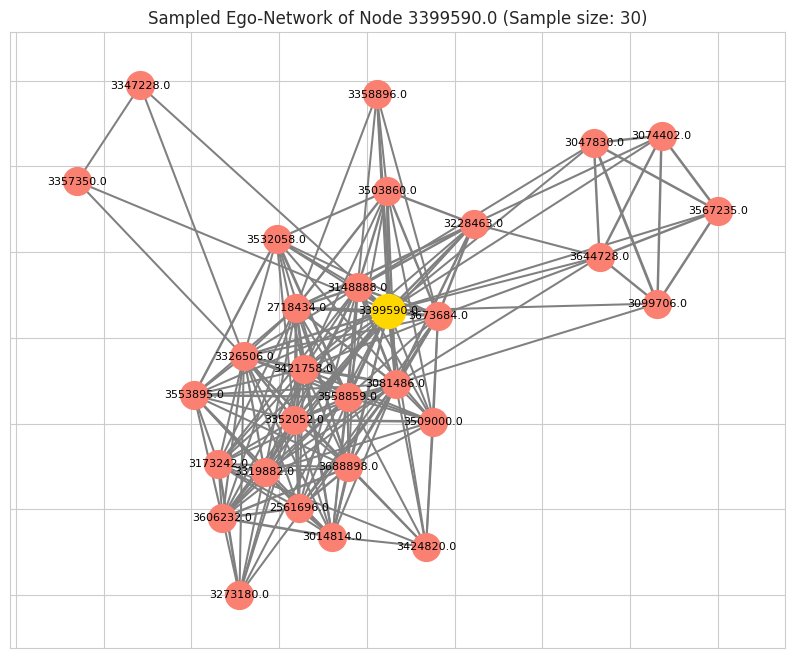

In [ ]:
def network_graph_sampling(G, central_node, sample_size=50):
  if central_node is None:
    degrees = dict(G.degree())
    central_node = max(degrees, key=degrees.get)
    print(f"Central node: {central_node}, degree: {degrees[central_node]}")

  ego = nx.ego_graph(G, central_node, radius=1)
  nodes_in_ego = list(ego.nodes())

  if sample_size >= len(nodes_in_ego):
    sampled_neighbors  = nodes_in_ego
  else:
    sampled_neighbors  = random.sample(nodes_in_ego, sample_size-1)

  sampled_nodes = [central_node] + sampled_neighbors
  sampled_ego = ego.subgraph(sampled_nodes)

  edge_weights = [ego[u][v].get('weight', 1.0) for u, v in sampled_ego.edges()]
  max_weight = max(edge_weights) if edge_weights else 1.0
  widths = [2 * (w / max_weight) for w in edge_weights]  # scale factor for visibility

  plt.figure(figsize=(10, 8))
  pos = nx.spring_layout(sampled_ego, seed=42)
  other_nodes = [n for n in sampled_ego.nodes() if n != central_node]
  nx.draw_networkx_nodes(sampled_ego, pos,
                          nodelist=other_nodes,
                          node_color='salmon',
                          node_size=400,
                          label='Neighbors')
  nx.draw_networkx_nodes(sampled_ego, pos,
                          nodelist=[central_node],
                          node_color='gold',
                          node_size=600,
                          label='Central Node')
  nx.draw_networkx_edges(sampled_ego, pos,
                          width=widths,
                          edge_color='gray')
  nx.draw_networkx_labels(sampled_ego, pos, font_size=8)
  plt.title(f"Sampled Ego-Network of Node {central_node} (Sample size: {len(sampled_nodes)})")
  plt.show()

network_graph_sampling(G, central_node=random.choice(index_to_node), sample_size=30)

In [ ]:
def leiden_community_detection(G, partition_type):
  G_igraph = ig.Graph.from_networkx(G)
  partition = leidenalg.find_partition(G_igraph, partition_type)
  print(f"Number of communities: {len(partition)}")

  modularity_scores = partition.modularity
  print(f"Modularity Score: {modularity_scores:.3f}")

  community_size = Counter(partition.membership)
  top_communities = [com for com, size in community_size.items() if size > 10]

leiden_community_detection(G, leidenalg.ModularityVertexPartition)

Number of communities: 64
Modularity Score: 0.919


In [ ]:
def centrality_metrics_networkit(G_nx):
    # Convert to NetworKit graph
    G_nk = nk.nxadapter.nx2nk(G_nx)

    deg = np.array(nk.centrality.DegreeCentrality(G_nk).run().scores())
    clo = np.array(nk.centrality.Closeness(G_nk, True, nk.centrality.ClosenessVariant.GENERALIZED).run().scores())
    bet = np.array(nk.centrality.Betweenness(G_nk, normalized=True).run().scores())
    avg = [(d + c + b) / 3 for d, c, b in zip(deg, clo, bet)]

    def minmax_normalization(x):
        return (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else np.zeros_like(x)

    deg_norm = minmax_normalization(deg)
    clo_norm = minmax_normalization(clo)
    bet_norm = minmax_normalization(bet)
    avg_norm = (deg_norm + clo_norm + bet_norm) / 3

    centrality_df = pd.DataFrame({
        "item": list(G_nx.nodes()),
        "average_centrality": avg,
        "average_centrality_normalized": avg_norm
    })

    centrality_df.to_csv("centrality.csv", index=False)

centrality_metrics_networkit(G)

In [ ]:
def recommendation_phase(data, id, ego, G, centrality_column, top_n=10, verbose=True):
  with open("top_k_neighbors.json") as f:
    top_k_neighbors = json.load(f)

  centrality_df = pd.read_csv("centrality.csv", dtype={'item': int})
  centrality_map = dict(zip(centrality_df["item"], centrality_df[centrality_column]))
  total_nodes = len(centrality_df)

  candidates = top_k_neighbors.get(str(ego), [])

  CEF = {}
  for neighbor, _ in candidates:
    neighbor = int(neighbor)
    d = 1
    CEF[neighbor] = centrality_map[neighbor] / (total_nodes * d)

  ranked = sorted(CEF.items(), key=lambda x: x[1], reverse=True)
  ranked = ranked[:top_n]

  result = data[data[id].isin([node for node, _ in ranked])].copy()
  result['CEF'] = [cef for _, cef in ranked]

  if verbose:
    print(f'⭐ \033[1mCourse Title\033[0m\t\t: {data[data[id] == ego]["title"].item()}')
    print(f'📌 Category\t\t: {data[data[id] == ego]["category"].item()}')
    print(f'➡️ Subcategory\t\t: {data[data[id] == ego]["subcategory"].item()}\n')

    print(f"\n✅ Top {top_n} recommendations for ego {int(ego)}:")
    for node, cef in ranked:
      print(f"Item {node} — CEF: {cef:.6f}")

  return result[['id', 'title', 'category', 'subcategory', 'CEF']]

In [ ]:
recommendation_phase(course_trim, id='id', ego=random.choice(index_to_node), G=G, centrality_column='average_centrality_normalized', top_n=10, verbose=True)

⭐ Course Title		: Agile Animated: Scrum & Kanban for any Business Environment
📌 Category		: Business
➡️ Subcategory		: Project Management


✅ Top 10 recommendations for ego 4028658:
Item 4351066 — CEF: 0.000008
Item 4242188 — CEF: 0.000008
Item 4058658 — CEF: 0.000007
Item 4071602 — CEF: 0.000007
Item 4166222 — CEF: 0.000007
Item 4082242 — CEF: 0.000007
Item 4248018 — CEF: 0.000007
Item 4260152 — CEF: 0.000007
Item 4155644 — CEF: 0.000007
Item 4414680 — CEF: 0.000007


,id,title,category,subcategory,CEF
149245,4058658.0,Project Management Alphabet A-Z,Business,Project Management,0.000008
150033,4071602.0,Risk Management for Everyone: Step by Step Pra...,Business,Project Management,0.000008
150712,4082242.0,Agile Project Management(English),Business,Project Management,0.000007
155178,4155644.0,Microsoft Project 2019,Business,Project Management,0.000007
155839,4166222.0,Project Cost Management and Sales Forecasting ...,Business,Project Management,0.000007
160898,4242188.0,Learn Project Management: How to Master Projec...,Business,Project Management,0.000007
161322,4248018.0,Learn Gantt Charts - The Ultimate Guide to Gan...,Business,Project Management,0.000007
162196,4260152.0,Learn How to Structure a Project in 30 Mins!,Business,Project Management,0.000007
168947,4351066.0,How to Gather Project Requirements,Business,Project Management,0.000007
174189,4414680.0,Key Agile concepts for PMP certification exam;...,Business,Project Management,0.000007


In [ ]:
recommendation_phase(course_trim, id='id', ego=random.choice(index_to_node), G=G, centrality_column='average_centrality', top_n=10, verbose=True)

⭐ Course Title		: Agile Animated: Scrum & Kanban for any Business Environment
📌 Category		: Business
➡️ Subcategory		: Project Management


✅ Top 10 recommendations for ego 4028658:
Item 4351066 — CEF: 0.002023
Item 4058658 — CEF: 0.001715
Item 4166222 — CEF: 0.001677
Item 4242188 — CEF: 0.001671
Item 4071602 — CEF: 0.001557
Item 4082242 — CEF: 0.001456
Item 4260152 — CEF: 0.001444
Item 4248018 — CEF: 0.001387
Item 4155644 — CEF: 0.001324
Item 4366754 — CEF: 0.001223


,id,title,category,subcategory,CEF
149245,4058658.0,Project Management Alphabet A-Z,Business,Project Management,0.002023
150033,4071602.0,Risk Management for Everyone: Step by Step Pra...,Business,Project Management,0.001715
150712,4082242.0,Agile Project Management(English),Business,Project Management,0.001677
155178,4155644.0,Microsoft Project 2019,Business,Project Management,0.001671
155839,4166222.0,Project Cost Management and Sales Forecasting ...,Business,Project Management,0.001557
160898,4242188.0,Learn Project Management: How to Master Projec...,Business,Project Management,0.001456
161322,4248018.0,Learn Gantt Charts - The Ultimate Guide to Gan...,Business,Project Management,0.001444
162196,4260152.0,Learn How to Structure a Project in 30 Mins!,Business,Project Management,0.001387
168947,4351066.0,How to Gather Project Requirements,Business,Project Management,0.001324
170247,4366754.0,Agile Management and Scrum + Career in Project...,Business,Project Management,0.001223
